In [ ]:
from tensorflow.keras.applications import EfficientNetV2L

model = EfficientNetV2L(weights='imagenet',
                        include_top=False,
                        input_shape=(224, 224, 3))


model.summary()

473176280/473176280 [==============================] - 6s 0us/step
Model: "efficientnetv2-l"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['rescaling[0][0]']           
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)             

In [ ]:
for layer in model.layers:
  layer.trainable = False

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

my_model = Sequential([model,
                       GlobalAveragePooling2D(),
                       Dense(512, activation='relu'),
                       Dropout(0.2),
                       Dense(512, activation='relu'),
                       Dropout(0.2),
                       Dense(1, activation='sigmoid')])

my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-l (Function  (None, 7, 7, 1280)        117746848 
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 512)               655872    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_3 (Dropout)         (None, 512)              

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf

BATCH_SIZE = 4
SEED = 1

train_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/cell_images',  # Update the path
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    shuffle=True,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',      # Specify 'training' subset for training dataset
    seed=SEED)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    '/content/drive/MyDrive/cell_images',  # Update the path
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(224, 224),
    shuffle=False,
    validation_split=0.2,  # Use 20% of the data for validation
    subset='validation',      # Specify 'training' subset for validation dataset
    seed=SEED
)


Found 17089 files belonging to 2 classes.
Using 13672 files for training.
Found 17089 files belonging to 2 classes.
Using 13672 files for training.


In [ ]:
iterator = iter(train_dataset)

In [ ]:
next(iterator)[0][0].numpy().shape

(224, 224, 3)

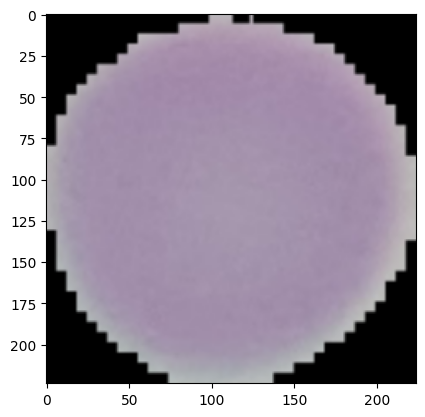

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(next(iterator)[0][0].numpy().astype(np.int32))

In [ ]:
from tensorflow.image import flip_left_right, adjust_brightness, adjust_contrast

def augment(image, label):
  image = flip_left_right(image)
  image = adjust_brightness(image, delta=0.1)
  image = adjust_contrast(image, contrast_factor=1.75)

  return (image, label)

train_dataset = train_dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)

iterator = iter(train_dataset)

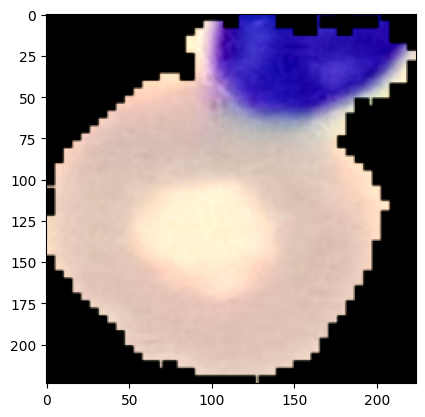

In [ ]:
plt.imshow(next(iterator)[0][0].numpy().astype(np.int32))

In [ ]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
from tensorflow.keras.metrics import *

metrics = ['accuracy', Precision(), Recall(), AUC()]

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

my_model.compile(loss=BinaryCrossentropy(),
                 optimizer=Adam(learning_rate=0.001),
                 metrics=metrics)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=3, monitor='val_loss')

In [ ]:
my_model.fit(train_dataset, epochs=1000,
             validation_data=val_dataset,
             callbacks=[es])

# Save the model
my_model.save('/content/drive/MyDrive/models/malaria_detection_model')


Epoch 1/50
3418/3418 [==============================] - 10945s 3s/step - loss: 0.1615 - accuracy: 0.9388 - precision: 0.9554 - recall: 0.9695 - auc: 0.9706 - val_loss: 0.0840 - val_accuracy: 0.9813 - val_precision: 1.0000 - val_recall: 0.9813 - val_auc: 0.0000e+00
Epoch 2/50
2040/3418 [================>.............] - ETA: 58:37 - loss: 0.1284 - accuracy: 0.9515 - precision: 0.9645 - recall: 0.9759 - auc: 0.9814

In [ ]:
from PIL import Image

image = Image.open('/content/drive/MyDrive/cell_images/Uninfected/C100P61ThinF_IMG_20150918_145422_cell_37.png')
image = image.resize((224, 224))
image

In [ ]:
img = np.asarray(image)

img.shape

In [ ]:
from copy import deepcopy

img_2 = deepcopy(img)

images = [img, img_2]

In [ ]:
# Define a function to predict and print the result
def predict_image(image_path):
    image = Image.open(image_path)
    image = image.resize((224, 224))
    img = np.asarray(image)
    prediction = my_model.predict(np.array([img]))[0]

    if prediction > 0.5:
        print("Infected")
    else:
        print("Uninfected")

# Example usage:
image_path = '/content/drive/MyDrive/cell_images/Uninfected/C100P61ThinF_IMG_20150918_145422_cell_37.png'
predict_image(image_path)


Epoch 1/1000
3418/3418 [==============================] - 328s 96ms/step - loss: 0.1054 - accuracy: 0.9605 - precision: 0.9722 - recall: 0.9791 - auc: 0.9866 - val_loss: 0.0764 - val_accuracy: 0.9725 - val_precision: 1.0000 - val_recall: 0.9725 - val_auc: 0.0000e+00
Epoch 2/1000
3418/3418 [==============================] - 341s 100ms/step - loss: 0.1020 - accuracy: 0.9634 - precision: 0.9749 - recall: 0.9799 - auc: 0.9864 - val_loss: 0.0643 - val_accuracy: 0.9775 - val_precision: 1.0000 - val_recall: 0.9775 - val_auc: 0.0000e+00
Epoch 3/1000
3418/3418 [==============================] - 334s 98ms/step - loss: 0.1001 - accuracy: 0.9634 - precision: 0.9740 - recall: 0.9808 - auc: 0.9875 - val_loss: 0.0923 - val_accuracy: 0.9710 - val_precision: 1.0000 - val_recall: 0.9710 - val_auc: 0.0000e+00
Epoch 4/1000
3418/3418 [==============================] - 327s 96ms/step - loss: 0.0967 - accuracy: 0.9642 - precision: 0.9739 - recall: 0.9820 - auc: 0.9881 - val_loss: 0.1125 - val_accuracy: 0.964

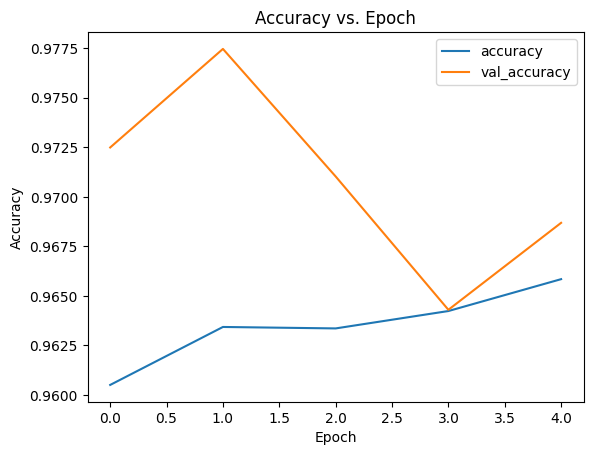

855/855 [==============================] - 72s 84ms/step - loss: 0.0917 - accuracy: 0.9687 - precision: 1.0000 - recall: 0.9687 - auc: 0.0000e+00
Validation Loss: 0.09170924872159958
Validation Accuracy: 0.9686859846115112
Validation Precision: 1.0
Validation Recall: 0.9686859846115112
Validation AUC: 0.0
1/1 [==============================] - 0s 47ms/step
Validation F1 Score: 0.9840939497547198
Validation Precision: 1.0
Validation Recall: 0.9686859818554288


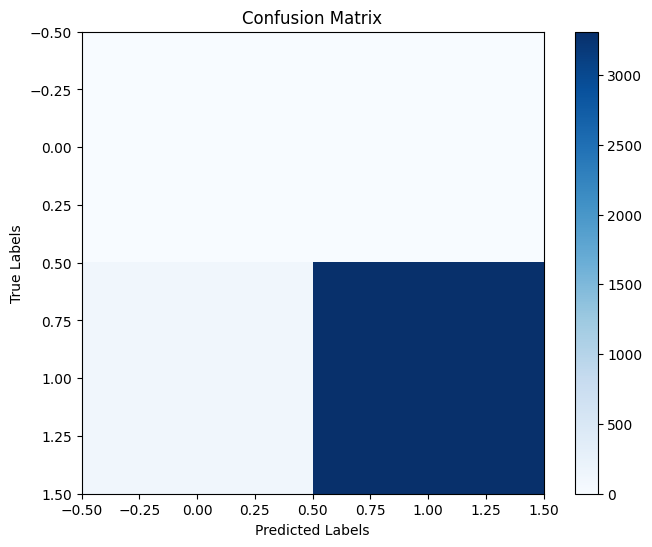

Classification Report:
              precision    recall  f1-score   support

  Uninfected       0.00      0.00      0.00         0
    Infected       1.00      0.97      0.98      3417

    accuracy                           0.97      3417
   macro avg       0.50      0.48      0.49      3417
weighted avg       1.00      0.97      0.98      3417



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

# Fit the model and store history for plotting accuracy vs. epoch graph
history = my_model.fit(train_dataset, epochs=1000,
                       validation_data=val_dataset,
                       callbacks=[es])

# Plot accuracy vs. epoch graph
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epoch')
plt.show()

# Evaluate the model on validation dataset
val_loss, val_accuracy, val_precision, val_recall, val_auc = my_model.evaluate(val_dataset)

print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')
print(f'Validation AUC: {val_auc}')

# Predict labels for validation dataset
val_predictions = []
val_true_labels = []

for images, labels in val_dataset:
    val_predictions.extend(my_model.predict(images).flatten())
    val_true_labels.extend(labels.numpy())

val_predictions = np.array(val_predictions) > 0.5

# Calculate and print F1 score, precision, and recall
val_f1 = f1_score(val_true_labels, val_predictions)
val_precision = precision_score(val_true_labels, val_predictions)
val_recall = recall_score(val_true_labels, val_predictions)

print(f'Validation F1 Score: {val_f1}')
print(f'Validation Precision: {val_precision}')
print(f'Validation Recall: {val_recall}')

# Plot confusion matrix
cm = confusion_matrix(val_true_labels, val_predictions)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print('Classification Report:')
print(classification_report(val_true_labels, val_predictions, target_names=['Uninfected', 'Infected']))


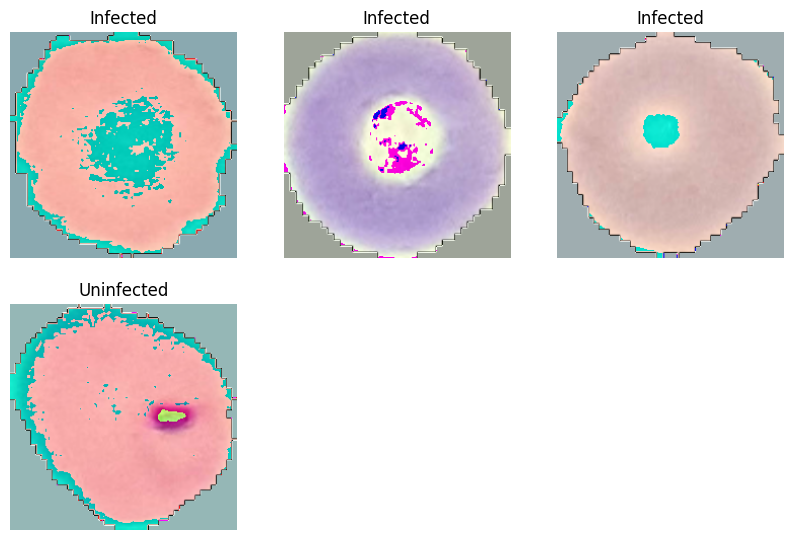

In [ ]:
import matplotlib.pyplot as plt

# Display a grid of sample images from the dataset
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        if labels[i] == 1:
            plt.title("Infected")
        else:
            plt.title("Uninfected")
        plt.axis("off")
plt.show()


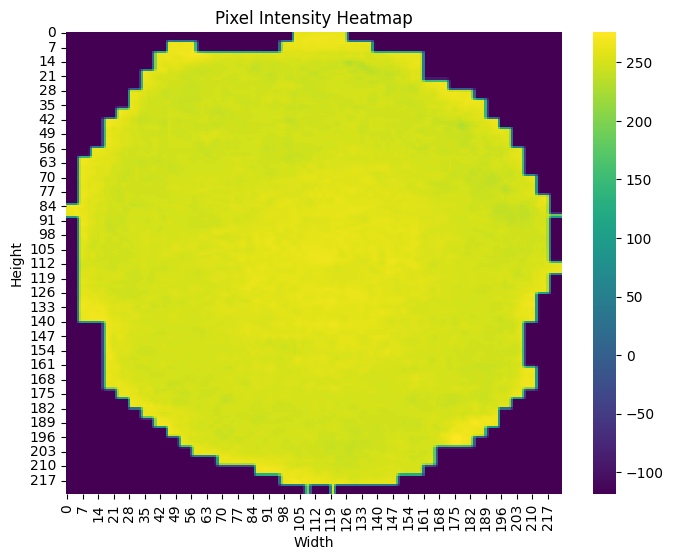

In [ ]:
import seaborn as sns

# Visualize pixel intensity distribution for a sample image
plt.figure(figsize=(8, 6))
sns.heatmap(images[0].numpy()[:,:,0], cmap='viridis')
plt.title('Pixel Intensity Heatmap')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


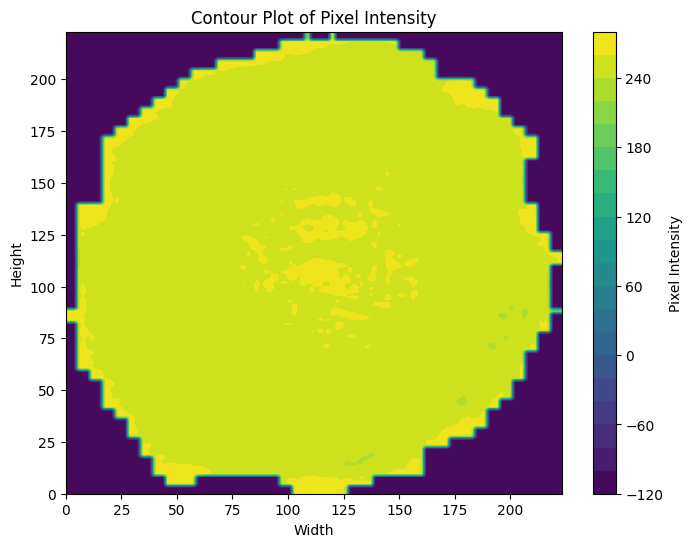

In [ ]:
# Plot contour of pixel intensity distribution for a sample image
plt.figure(figsize=(8, 6))
plt.contourf(images[0].numpy()[:,:,0], cmap='viridis', levels=20)
plt.colorbar(label='Pixel Intensity')
plt.title('Contour Plot of Pixel Intensity')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()


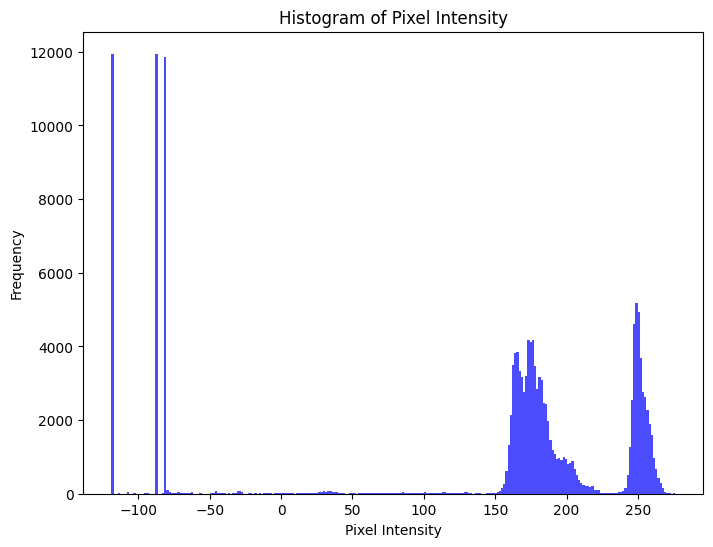

In [ ]:
# Plot histogram of pixel intensity distribution for a sample image
plt.figure(figsize=(8, 6))
plt.hist(images[0].numpy().ravel(), bins=256, color='blue', alpha=0.7)
plt.title('Histogram of Pixel Intensity')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()


1/1 [==============================] - 2s 2s/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1020: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


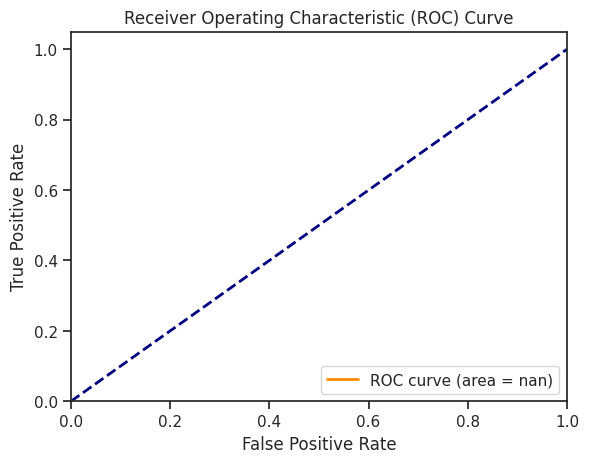

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
y_true = []
y_score = []

# Collect true labels and predicted scores from a subset of the validation dataset
for images, labels in val_dataset.take(10):  # Take only 10 batches (or adjust as needed)
    y_true.extend(labels.numpy())
    y_score.extend(my_model.predict(images).flatten())

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


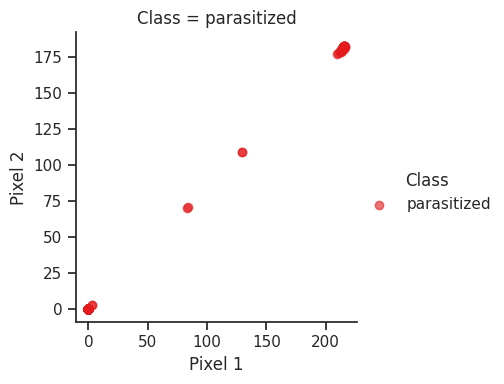

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Collect a subset of the validation dataset
subset_images = []
subset_labels = []
for images, labels in val_dataset.take(100):  # Take only 10 batches (adjust as needed)
    subset_images.extend(images.numpy())
    subset_labels.extend(labels.numpy())

# Convert lists to arrays
subset_images = np.array(subset_images)
subset_labels = np.array(subset_labels)

# Flatten the images
subset_images_flat = subset_images.reshape((-1, subset_images.shape[-1]))

# Ensure the lengths of arrays are consistent
min_length = min(len(subset_labels), subset_images_flat.shape[0])
subset_labels = subset_labels[:min_length]
subset_images_flat = subset_images_flat[:min_length]

# Convert labels to class names
class_names = np.array(['uninfected', 'parasitized'])[subset_labels]

# Create a DataFrame
df = pd.DataFrame({'Pixel 1': subset_images_flat[:, 0],
                   'Pixel 2': subset_images_flat[:, 1],
                   'Class': class_names})

# Create scatter plot with facet grids
sns.set(style="ticks")
g = sns.FacetGrid(df, col="Class", hue="Class", palette="Set1", height=4)
g.map(plt.scatter, "Pixel 1", "Pixel 2", alpha=0.6)
g.add_legend()
plt.show()


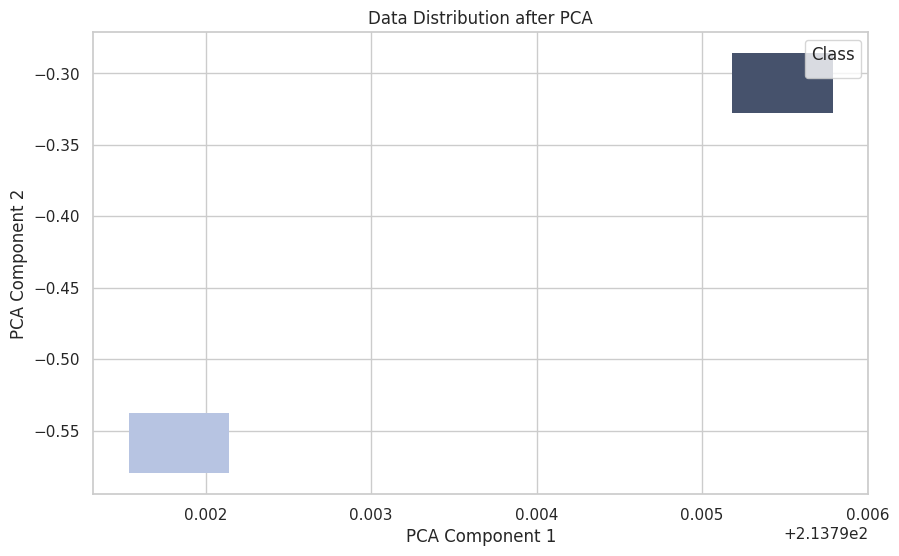

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA

# Collect a subset of the validation dataset
subset_images = []
subset_labels = []
for images, labels in val_dataset.take(10):  # Take only 10 batches (adjust as needed)
    subset_images.extend(images.numpy())
    subset_labels.extend(labels.numpy())

# Convert lists to arrays
subset_images = np.array(subset_images)
subset_labels = np.array(subset_labels)

# Flatten the images
subset_images_flat = subset_images.reshape((-1, subset_images.shape[-1]))

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
subset_images_pca = pca.fit_transform(subset_images_flat)

# Ensure the lengths of arrays are consistent
min_length = min(len(subset_labels), subset_images_pca.shape[0])
subset_labels = subset_labels[:min_length]
subset_images_pca = subset_images_pca[:min_length]

# Convert labels to class names
class_names = np.array(['Uninfected', 'Infected'])[subset_labels]

# Create a DataFrame
df = pd.DataFrame({'PCA Component 1': subset_images_pca[:, 0],
                   'PCA Component 2': subset_images_pca[:, 1],
                   'Class': class_names})

# Plot data distribution
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='PCA Component 1', y='PCA Component 2', hue='Class', element='step', kde=True, stat='density', common_norm=False)
plt.title('Data Distribution after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Class')
plt.show()


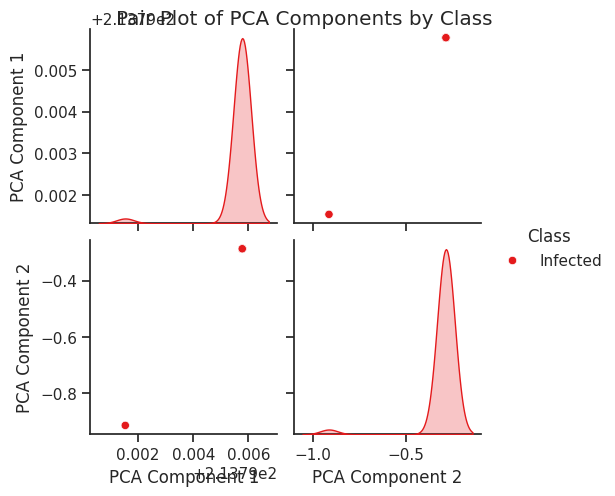

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Collect a subset of the validation dataset
subset_images = []
subset_labels = []
for images, labels in val_dataset.take(10):  # Take only 10 batches (adjust as needed)
    subset_images.extend(images.numpy())
    subset_labels.extend(labels.numpy())

# Convert lists to arrays
subset_images = np.array(subset_images)
subset_labels = np.array(subset_labels)

# Flatten the images
subset_images_flat = subset_images.reshape((-1, subset_images.shape[-1]))

# Perform PCA for dimensionality reduction
pca = PCA(n_components=2)
subset_images_pca = pca.fit_transform(subset_images_flat)

# Ensure the lengths of arrays are consistent
min_length = min(len(subset_labels), subset_images_pca.shape[0])
subset_labels = subset_labels[:min_length]
subset_images_pca = subset_images_pca[:min_length]

# Convert labels to class names
class_names = np.array(['Uninfected', 'Infected'])[subset_labels]

# Create a DataFrame
df = pd.DataFrame({'PCA Component 1': subset_images_pca[:, 0],
                   'PCA Component 2': subset_images_pca[:, 1],
                   'Class': class_names})

# Plot pair plot
sns.set(style="ticks")
sns.pairplot(df, hue="Class", palette="Set1")
plt.suptitle('Pair Plot of PCA Components by Class')
plt.show()


In [ ]:
import tensorflow as tf

# Get the number of elements in the validation dataset
num_val_images = tf.data.experimental.cardinality(val_dataset).numpy()

print("Number of images in the validation dataset:", num_val_images)


Number of images in the validation dataset: 855


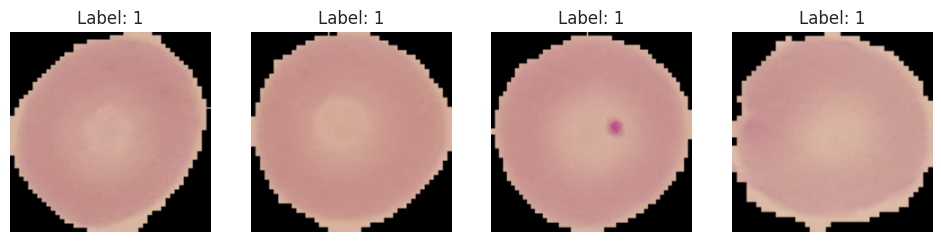

In [ ]:
import matplotlib.pyplot as plt

# Display five images from the validation dataset if available
plt.figure(figsize=(15, 8))
for images, labels in val_dataset.take(1):  # Take one batch from the dataset
    for i in range(min(5, len(images))):  # Display up to five images
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("Label: {}".format(labels[i].numpy()))
        plt.axis("off")
plt.show()


In [ ]:
found_uninfected = False

# Iterate through the validation dataset until at least one uninfected image is found
for images, labels in val_dataset:
    for label in labels.numpy():
        if label == 0:
            found_uninfected = False
            break
    if found_uninfected:
        break

if found_uninfected:
    print("At least one uninfected image is present in the validation dataset.")
else:
    print("No uninfected images found in the validation dataset.")


No uninfected images found in the validation dataset.
